# Semantic Segment Road and Sidewalk
Tony Wang July 04 2023

After semantic segmentation of road and sidewalk, we obtain the pixel level binary mask of them. Which can be used to detect human-road relationship using rule-based comparision. Since the SAM didn't provide necessary api, I write some utility func to realize it

> This notebook is used for tutuorial demo, because I believe, compared to the unstable .py file, jupyter notebook would provide a vivid description and data pipeline demonstration.



## Library & Model Loading

In [2]:
import os
import cv2
# filter some annoying debug info
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import supervision as sv

import numpy as np
from PIL import Image
from pathlib import Path

import termcolor
import matplotlib.pyplot as plt

from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor
#TODO name!
from groundingdino.util.inference import load_model, load_image, predict, annotate

# import SAM_utility # 

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Paths to GroundingDINO and SAM checkpoints
GROUNDING_DINO_CONFIG_PATH = "/root/autodl-tmp/DINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "/root/autodl-tmp/DINO/weights/groundingdino_swint_ogc.pth"
MODEL_TYPE = "default"
SAM_CHECKPOINT_PATH = "/root/autodl-tmp/sam_vit_h_4b8939.pth"

# Predict classes and hyper-param for GroundingDINO
BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.25
NMS_THRESHOLD = 0.8

In [22]:
DEBUG = True

The model loading is quite long
with some unremovable warning in gDINO, just ignore it

In [3]:
# Initialize GroundingDINO model
grounding_dino_model = Model(
    model_config_path=GROUNDING_DINO_CONFIG_PATH, 
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH, 
    device=DEVICE
)

# Initialize SAM model and predictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Utility Function

In [4]:

def show_mask(mask, ax, random_color=False):
    '''Display single mask to its image'''
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:] # more robust way of extracting the spatial dimensions of the array
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [5]:
mask = np.array([[0,0,0,0,0],[0,1,1,1,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,0,0,0],[0,0,1,0,0]])
# mask2 = np.array([[[0,0,0,0,0],[1,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[1,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]])
mask2 = np.array([[0,0,0,0,0],[0,1,1,1,0],[0,0,1,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])
# mask3 = np.array([[[0,0,0,0,0],[1,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]],[[0,0,0,0,0],[1,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]])
# mask4 = np.array([[0,0,0,0,0],[0,1,1,1,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,0,0,0],[0,0,1,0,0]])

# print(mask,'\n',mask2)
# overlap = np.logical_and(mask3, mask2)
# print(overlap)
# yesorno = np.any(overlap)
# print("yes or no : ",yesorno)

mask2.shape[-2:]
halfway_point = mask.shape[0] //2
print(halfway_point)
print(mask)
print("next")
# mask[:halfway_point,:] = 0
print(mask[halfway_point:])

3
[[0 0 0 0 0]
 [0 1 1 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]]
next
[[0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]]


In [24]:
def is_image_file(filename):
    IMAGE_EXT = ['.jpg', '.jpeg', '.png', '.bmp']
    return any(filename.endswith(extension) for extension in IMAGE_EXT)

DISPLAY_FLAG = False
def display_mask(SAM_masks,P_masks, P_boxes, DINO_boxes,  person_annotation,output_path):
    # Create a new subplot
    plt.figure(figsize=(16,9))
    # image = cv2.cvtColor( cv2.imread(image_path),cv2.COLOR_BGR2RGB )
    # Display the original image
    plt.axis('off')
    # if DISPLAY_FLAG:
        # plt.imshow(image)
    plt.imshow(person_annotation)
    i,j,k,d = 1,1,1,1
    for mask in SAM_masks:
        i += 1
        show_mask(mask, plt.gca(), random_color=True)
    for box in DINO_boxes:
        j += 1
        show_box(box, plt.gca())
    for mask in P_masks:
        k += 1
        show_mask(mask, plt.gca(), random_color=True)
    for box in P_boxes:
        d += 1
        show_box(box,plt.gca())
    print("number of SAM, ROAD, P, BOXES: ",i,j,k,d)

    plt.savefig(output_path)
    plt.close()
    return (i, j, k, d)


In [7]:
def nms_processing(detections ):
    nms_idx = torchvision.ops.nms(
        torch.from_numpy(detections.xyxy), 
        torch.from_numpy(detections.confidence), 
        NMS_THRESHOLD
    ).numpy().tolist()

    detections.xyxy = detections.xyxy[nms_idx]
    detections.confidence = detections.confidence[nms_idx]
    detections.class_id = detections.class_id[nms_idx]
    return detections


## Architecture:
1. gDINO : grounding_dino_model.predict_with_classes

   CLASSES_prompt= ['road', 'sidewalk']

   Based on testing, this pair is most reliable (otherwise the sidewalk may messed up with road) 

   In this part, I use the box as Region of Interest(ROI) to further prompt SAM

2. Non-maximum suppression (NMS) :

   get rid of redundant and overlapping bounding boxes.

   the metric is Intersection over Union(IoU)

3. Prompting SAM with ROI, select mask with largest area, in this step, the road and sidewalk can be segmented with naming in pixel level accuracy.

4. save the result 

5. label the result with label and confidence

6. TODO: do image sequence experiment, analyze the behavior of person

7. TODO: split cases based on JAAD info

   - car is moving 
   - car is stopping
   - time
   - weather
   - more...

In GTX3090 environment, the algorithm runs relatively fast with GPU boosting.

(Not as bad as I guessed before, much faster than all of the online demo)


In [8]:
def is_overlap(mask_a: np.ndarray, mask_b: np.ndarray):
    """
    Check if the bottom part of mask_a overlaps with mask_b.
    
    Args:
        mask_a: numpy array of shape (H, W). Binary mask of object A.
        mask_b: numpy array of shape (H, W). Binary mask of object B.

    Returns:
        bool. True if there is overlap, False otherwise.
    """
    
    # Check the inputs are binary masks
    assert mask_a.shape == mask_b.shape, "Both masks should have the same shape."
    assert np.logical_or(mask_a == 0, mask_a == 1).all(), "Mask A should be a binary mask."
    assert np.logical_or(mask_b == 0, mask_b == 1).all(), "Mask B should be a binary mask."

    # Find the lowest true point in mask A 
    y_coords, _ = np.nonzero(mask_a)
    lowest_point = np.max(y_coords) - 10 #(huamn feet point)

    mask_a_copy = mask_a.copy()
    # Slice mask A from the lowest point to the top
    mask_a_copy[:lowest_point, :] = 0

    # Check for overlap
    overlap = np.logical_and(mask_a_copy, mask_b)

    return np.any(overlap), lowest_point


In [27]:
def write_to_txt(txt_path, img_name, p_surface_overlaps, counts, labels, p_labels):
    with open(txt_path, 'a') as f: # 'a' option is for appending to the file if it exists
        f.write(f"INFO of {img_name}:\n")
        for person, surfaces in p_surface_overlaps:
            if surfaces:
                surface_str = ', '.join([f"{surface.object_type} {surface.id}" for surface in surfaces])
                f.write(f"Person {person.id} is on the {surface_str}\n")
            else:
                f.write(f"Person {person.id} is not on any detected surface\n")
                
        f.write(f"number of SAM, ROAD, P, BOXES: {counts}\n")
        f.write(f"Labels: [{', '.join(labels)}]\n")
        f.write(f"Person Labels: [{', '.join(p_labels)}]\n")
        f.write("\n")





## Functional part

In [18]:
class LocationInfo:
    def __init__(self, object_type, id, box, mask,confidence):
        self.object_type = object_type  # ('sidewalk', 'road', or 'person')
        self.id = id  # Unique ID within the type
        self.box = box  # Bounding box in xyxy format
        self.mask = mask  # Binary mask indicating the precise location of the object
        self.confidence = confidence

    def __str__(self):
        return f"Type: {self.object_type}, ID: {self.id}, Box: {self.box}"
    
    def overlay_on_image(self, image, color=None):
        """
        Overlay the mask of the object on the given image.

        Parameters:
        image (numpy.ndarray): Image to overlay the mask on.
        color (tuple): RGB color for the mask. If None, a random color is chosen.

        Returns:
        numpy.ndarray: The image with the mask overlaid.
        """
        if color is None:
            # If no color is specified, generate a random color
            color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))

        # Create an image of the same size but with the mask color where the mask is
        mask_img = np.zeros_like(image)
        mask_img[self.mask] = color

        # Combine the mask image with the original image
        combined = cv2.addWeighted(image, 0.7, mask_img, 0.3, 0)

        return combined

    def get_area(self):
        """
        Calculate the area of the object based on its mask.
        TODO: multply by shape?
        Returns:
        int: The area of the object in pixels.
        """
        return np.sum(self.mask)


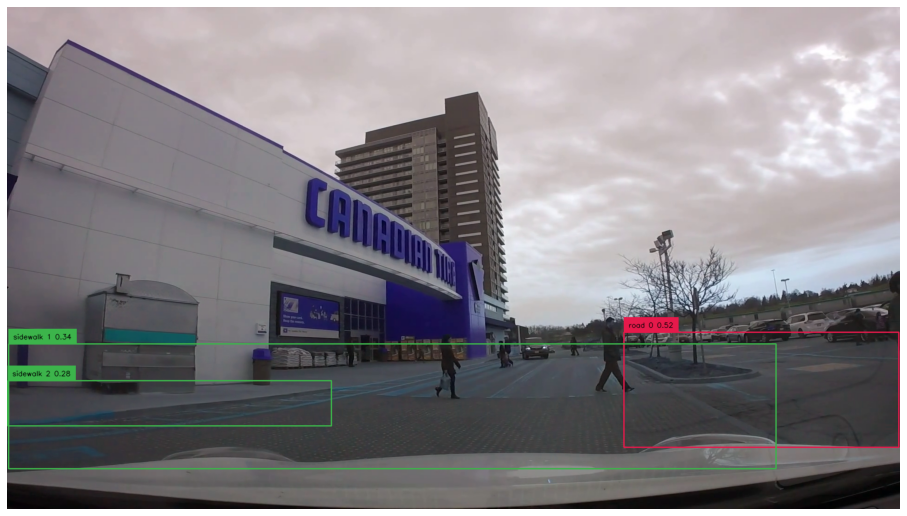

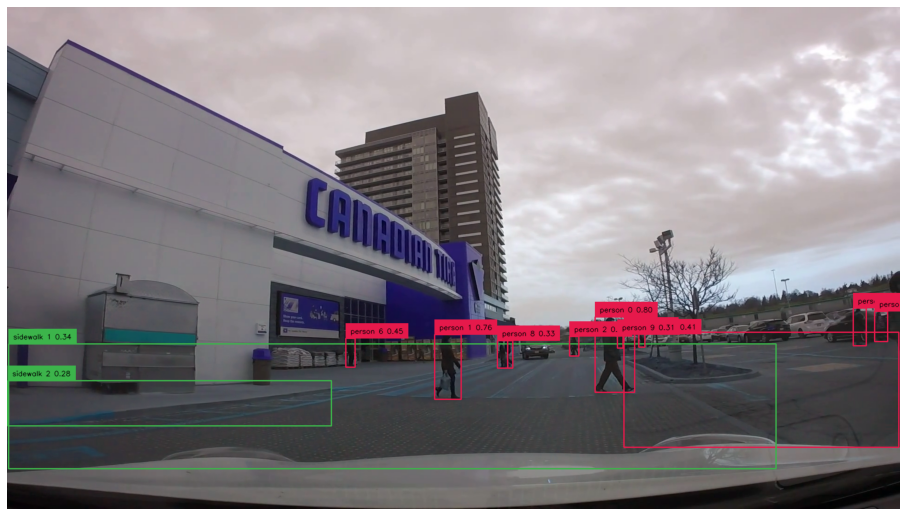

Person 0 is on the road 0, sidewalk 1, sidewalk 2
Person 1 is on the road 0, sidewalk 1, sidewalk 2
Person 2 is on the road 0, sidewalk 1, sidewalk 2
Person 3 is not on any detected surface
Person 4 is not on any detected surface
Person 5 is not on any detected surface
Person 6 is not on any detected surface
Person 7 is not on any detected surface
Person 8 is not on any detected surface
number of SAM, ROAD, P, BOXES:  10 4 10 11


ValueError: too many values to unpack (expected 4)

In [29]:
from collections import Counter

# Prompting SAM with Region of Interest
def segment_ROI(sam_predictor: SamPredictor, image: np.ndarray, boxes: np.ndarray):
    sam_predictor.set_image(image)
    result_masks = []
    for box in boxes:
        masks_np, scores_np, _ = sam_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=box,
        multimask_output=True,
        )
        # Remove the following line to get all the person masks
        # index = np.argmax(scores_np) 
        # Add all masks to the result, not just the one with the highest score
        for mask in masks_np:
            result_masks.append(mask)

    return np.array(result_masks)


def detect_road(image_path,output_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image at path {image_path} could not be loaded. Skipping.")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    except Exception as e:
        print(f"Failed to process image at {image_path}. Error: {e}")
        return None
    
    TEXT_PROMPT = "road . sidewalk"
    ROAD_SIDEWALK = ['road', 'sidewalk'] 
    P_CLASS     = ['person',]
    # the person label lower gDINO's performance
    # so I split them

    # detect road and sidewalk
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes = ROAD_SIDEWALK,
        box_threshold= BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    detections = nms_processing(detections)
    # detect person 
    p_detections = grounding_dino_model.predict_with_classes(
        image = image,
        classes = P_CLASS , 
        box_threshold= BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    p_detections = nms_processing(p_detections)

    box_annotator = sv.BoxAnnotator()
    person_annotator = sv.BoxAnnotator()

    labels = [
        f"{ROAD_SIDEWALK[class_id]} {i} {confidence:0.2f}" 
        for i, (_, _, confidence, class_id, _) in enumerate(detections)]

    P_labels = [
        f"{P_CLASS[class_id]} {i} {confidence:0.2f}" 
        for i, (_, _, confidence, class_id, _) in enumerate(p_detections)]

    DINO_boxes = np.array(detections.xyxy)
    P_boxes    = np.array(p_detections.xyxy)
    
    annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections ,labels=labels)
    if DEBUG:
        sv.plot_image(annotated_frame, (16, 16))
    person_annotation = person_annotator.annotate(scene=annotated_frame,detections= p_detections,labels= P_labels)
    if DEBUG:
        sv.plot_image(person_annotation, (16, 16))
    # cv2.imwrite("annotated_image.jpg", annotated_frame)
    
    SAM_masks = segment_ROI(sam_predictor,image,DINO_boxes)
    P_masks = segment_ROI(sam_predictor,image,DINO_boxes)

    # Create a list of LocationInfo objects for each detected object
    obj_dict = Counter()
    
    for i, (box, label, mask) in enumerate(zip(DINO_boxes, labels, SAM_masks)):
        object_type, id, confidence   = label.split(' ')
        index = object_type +id
        obj_dict[index] =  (LocationInfo(object_type, int(id), box, mask,confidence)) 

    for i, (box, label, mask) in enumerate(zip(P_boxes, P_labels, P_masks)):
        object_type, id, confidence = label.split(' ')
        index = object_type+id
        obj_dict[index] = (LocationInfo(object_type, int(id), box, mask,confidence)) 

    # Analyze where each person is standing
    p_surface_overlaps = []

    for name, person in obj_dict.items():
        if person.object_type != "person":
            continue # We only want to analyze persons

        overlaps = []
        for name, surface in obj_dict.items():
            # We only want to analyze surfaces (road or sidewalk)
            if surface.object_type not in ROAD_SIDEWALK: 
                continue

            # Check if the person and the surface overlap
            overlap, _ = is_overlap(person.mask, surface.mask)
            if overlap:
                overlaps.append(surface)

        p_surface_overlaps.append((person, overlaps))

    



    if DEBUG:
        # Print out the analysis results
        for person, surfaces in p_surface_overlaps:
            if surfaces:
                surface_str = ', '.join([f"{surface.object_type} {surface.id}" for surface in surfaces])
                print(f"Person {person.id} is on the {surface_str}")
            else:
                print(f"Person {person.id} is not on any detected surface")

    (i, j, k, d) = display_mask(SAM_masks,P_masks,P_boxes,DINO_boxes,person_annotation,output_path)
    
    output_dir = Path(output_path).parent
    img_name = image_path[-4:-1]
    txt_name = "Info_Video_"+ img_name +".txt"
    txt_path = os.path.join(output_dir, txt_name) 
    write_to_txt(txt_path, img_name, p_surface_overlaps, (i, j, k, d), labels, P_labels)

    plt.close()
    
    return DINO_boxes,labels,P_labels,SAM_masks,P_masks
    # text program to make sure the label works
# DINO_boxes,labels,SAM_masks,P_masks = detect_road("input/scene_2.png",output_path="SSS")
DINO_boxes,labels,P_labels,SAM_masks,P_masks = detect_road("input/video_0031/image_0005.png",output_path="DINOmasked/man.png")
# DINO_boxes,labels,P_labels,SAM_masks,P_masks = detect_road("input/video_0268/image_0001.png",output_path="SSS")

# print("Labels: ", labels)
# print("Person Labels: ", P_labels)


In [ ]:
.id} is on the {surface_str}")
            else:
                print(f"Person {person.id} is not on any detected surface")

    (i, j, k, d) = display_mask(SAM_masks,P_masks,P_boxes,DINO_boxes,person_annotation,output_path)
    
    output_dir = Path(output_path).parent
    img_name = image_path[-4:-1]
    txt_name = "Info_Video_"+ img_name +".txt"
    txt_path = os.path.join(output_dir, txt_name) 
    write_to_txt(txt_path, img_name, p_surface_overlaps, (i, j, k, d), labels, P_labels)

    plt.close()
    
    return DINO_boxes,labels,P_labels,SAM_masks,P_masks
    # text program to make sure the label works
# DINO_boxes,labels,SAM_masks,P_masks = detect_road("input/scene_2.png",output_path="SSS")
# DINO_boxes,labels,SAM_masks,P_masks = detect_road("input/video_0031/image_0005.png",output_path="SSS")
DINO_boxes,labels,P_labels,SAM_masks,P_masks = detect_road("input/video_0268/image_0001.png",output_path="SSS")
print("Labels: ", labels)
print("Person Labels: ", P_labels)


## task: to obtain a robust and clear data structure,create a class for each element detected

class locat_info # complete this class
''' it should contain
 1. str type: [sidewalk,road or person]
 2. int id: the uniuque number within the type
 3. np.array box: bbox in xyxy format
 4. np.array mask: binary mask to indicate its precise location
 5. ...other suggestion that helps for our task 
'''


In [ ]:
wds

In [ ]:
result_masks = []
mask = [  1.7368164 ,187.55162,   893.4925 ,   430.34235  ]
score = np.array( [  1.7368164 ,187.55162,   893.4925 ,   430.34235  ])
index = np.argmax(score)
result_masks.append(mask[index])
result_masks


[893.4925]

In [ ]:
ssss

NameError: name 'ssss' is not defined

## Main Function

In [ ]:
input_dir = Path("input") # contain many folder 
output_dir = Path('DINOmasked')
output_dir.mkdir(parents=True, exist_ok=True)

print("===== Start =====")
i = 1
# Use rglob to recursively find all image files
for image_path in input_dir.rglob('*'):
    if is_image_file(str(image_path)):
        relative_path = image_path.relative_to(input_dir)

        output_path = output_dir / relative_path
        output_path.parent.mkdir(parents=True,exist_ok=True)

        if not output_path.exists():
            print("Processing: ", i)
            i += 1
            print(f"Image path: {termcolor.colored(os.path.basename(str(image_path)), 'green')}")

            result = detect_road(str(image_path),str(output_path))

            if result is not None:
                print(f"Detected: {image_path}") # {termcolor.colored(result, 'blue')}")
            else:
                fail_str = "failed to detect result"
                print(f" {termcolor.colored(fail_str, 'red')}")


NameError: name 'Path' is not defined

In [ ]:
def is_image_file(filename):
    IMAGE_EXT = ['.jpg', '.jpeg', '.png', '.bmp']
    return any(filename.endswith(extension) for extension in IMAGE_EXT)


In [ ]:
input_dir  = Path("input")
i = 0
for image_path in input_dir.rglob('*'):
    if i > 30: break
    
    if is_image_file(str(image_path)):
        i += 1

        print("image path is" ,image_path)
        relative_path = image_path.relative_to(input_dir)

        output_filename = 'D_' + relative_path.name
        
        output_path = Path(os.path.join( output_dir , output_filename))
        print("output_path path is" ,output_path)
        output_path.parent.mkdir(parents=True,exist_ok=True)


image path is input/man.png
output_path path is DINOmasked/D_man.png
image path is input/man_black.png
output_path path is DINOmasked/D_man_black.png
image path is input/scene_2.png
output_path path is DINOmasked/D_scene_2.png
image path is input/scene_2_black.png
output_path path is DINOmasked/D_scene_2_black.png
image path is input/video_0018/image_0001.png
output_path path is DINOmasked/D_image_0001.png
image path is input/video_0018/image_0002.png
output_path path is DINOmasked/D_image_0002.png
image path is input/video_0018/image_0003.png
output_path path is DINOmasked/D_image_0003.png
image path is input/video_0018/image_0004.png
output_path path is DINOmasked/D_image_0004.png
image path is input/video_0018/image_0005.png
output_path path is DINOmasked/D_image_0005.png
image path is input/video_0018/image_0006.png
output_path path is DINOmasked/D_image_0006.png
image path is input/video_0018/image_0007.png
output_path path is DINOmasked/D_image_0007.png
image path is input/video_